d:\Capstone\El Nino\venv\Lib\site-packages\tcn\tcn.py:227: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)



Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.5512
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9159
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5890
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1409
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1983
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0340
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0819 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0469
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0326
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0368
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0268
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0292
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0358
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0267
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0182
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━

C:\Users\rumma\AppData\Local\Temp\ipykernel_3992\1569697798.py:107: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df_location.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")


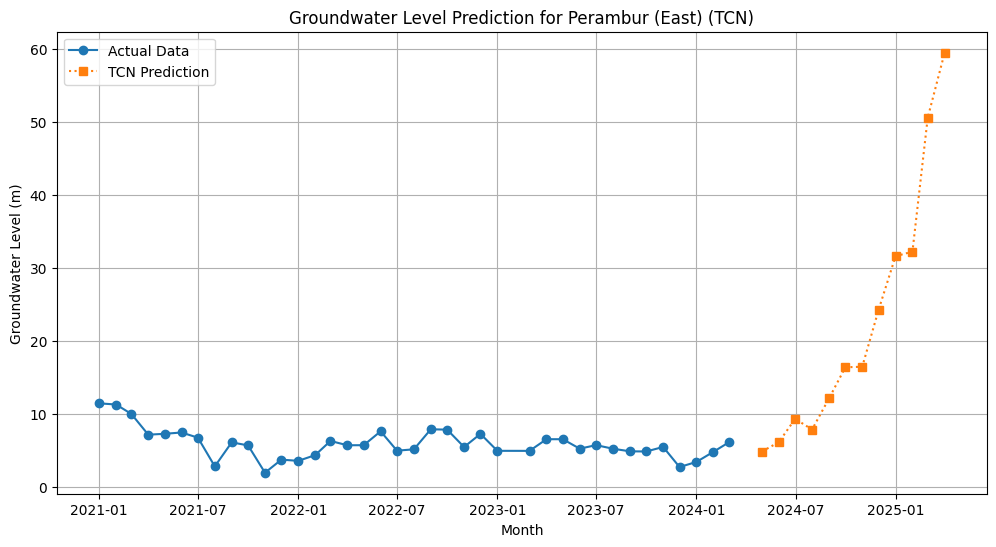

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tcn import TCN  # Make sure tcn is installed using `pip install tcn`

# File paths for 2021-2024 datasets
file_paths = {
    2021: "../dataset/chennai-ground-water-levels-2021.csv",
    2022: "../dataset/chennai-ground-water-levels-2022.csv",
    2023: "../dataset/chennai-ground-water-levels-2023.csv",
    2024: "../dataset/chennai-ground-water-levels-2024.csv"
}

# Load all datasets into a single DataFrame
df_list = []
for year, path in file_paths.items():
    df = pd.read_csv(path)
    df["Year"] = year  # Add Year column
    df_list.append(df)

df_all_years = pd.concat(df_list)

# Fix month column names by stripping spaces
df_all_years.rename(columns=lambda x: x.strip(), inplace=True)

# Updated month list without spaces
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Convert to numeric
df_all_years[months] = df_all_years[months].apply(pd.to_numeric, errors='coerce')

# Select a specific location for forecasting (e.g., Perambur (East))
location = "Perambur (East)"
df_location = df_all_years[df_all_years["Location"] == location][["Year"] + months]

# Reshape into time series format
df_location = df_location.set_index("Year").stack().reset_index()
df_location.columns = ["Year", "Month", "Groundwater Level"]

# Strip extra spaces from Month column values
df_location["Month"] = df_location["Month"].str.strip()

# Convert to datetime
df_location["Date"] = pd.to_datetime(df_location["Year"].astype(str) + "-" + df_location["Month"], format="%Y-%b", errors="coerce")

# Drop any NaN values and set Date as index
df_location = df_location[["Date", "Groundwater Level"]].dropna()
df_location.set_index("Date", inplace=True)

# Normalize Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_location)

# Prepare Data for TCN
sequence_length = 6  # Using last 6 months to predict the next month
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i + sequence_length])
    y.append(data_scaled[i + sequence_length])

X, y = np.array(X), np.array(y)

# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define TCN Model
def build_tcn_model():
    model = Sequential()
    model.add(TCN(input_shape=(sequence_length, 1)))  # TCN layer
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=Adam(), loss='mse')
    return model

# Build and train the TCN model
tcn_model = build_tcn_model()
tcn_model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1)

# Predict on the test set
tcn_preds = tcn_model.predict(X_test)

# Compute RMSE
tcn_rmse = np.sqrt(mean_squared_error(y_test, tcn_preds))
print(f"TCN RMSE: {tcn_rmse:.4f}")

# Predict Next 12 Months
future_predictions_tcn = []
input_seq = X[-1].reshape(1, sequence_length, 1)

for _ in range(12):  # Predict next 12 months
    next_value_tcn = tcn_model.predict(input_seq)[0]
    future_predictions_tcn.append(next_value_tcn)
    
    input_seq = np.append(input_seq[:, 1:], [[next_value_tcn]], axis=1)  # Slide window

# Convert back to original scale
future_predictions_tcn = scaler.inverse_transform(np.array(future_predictions_tcn).reshape(-1, 1))

# Generate future dates
future_dates = pd.date_range(start=df_location.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(df_location.index, df_location["Groundwater Level"], marker='o', label="Actual Data")
plt.plot(future_dates, future_predictions_tcn, marker='s', linestyle="dotted", label="TCN Prediction")
plt.xlabel("Month")
plt.ylabel("Groundwater Level (m)")
plt.title(f"Groundwater Level Prediction for {location} (TCN)")
plt.legend()
plt.grid()
plt.show()
